<a href="https://colab.research.google.com/github/Danionon/PRIRlab11/blob/main/PRIRlab11a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source
https://github.com/tomwalczak/food-vision-mobile-tensorflowjs

# Intro to Food Vision Mobile 🍔 👀📱

(This project was inspired by [@mrdbourke's](https://github.com/mrdbourke) excellent TF course, check it out: [Tensorflow Deep Learning](https://github.com/mrdbourke/tensorflow-deep-learning) )

## See the live app [here](https://tomwalczak.github.io/food-vision-mobile-tensorflowjs/)

I was curious about how two well-known models, ResNet50 and ImageNet (trained on Food101 dataset), would perform runnining on a smartphone, in a browser using TensorFlow JS.

Using TFJS makes it very easy to test these models in the wild - would they perform OK?

My approach was to extract image features from ResNet50V2, ImageNetV2, fit them to Food101 dataset (10% and 100%) and finally convert them to Tensorflow JS.

#Load helper functions

In [17]:
import tensorflow as tf

In [18]:
# Get helper functions file (credit: @mrdbourke)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-31 07:43:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-31 07:43:41 (63.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [19]:
# View random images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_images(target_dir, target_class, how_many=9):
  # Set up target folder
  target_folder = target_dir + target_class

  how_many = 16 if (how_many > 16 or how_many < 1) else how_many
  
  # Get a random image path
  random_images = random.sample(os.listdir(target_folder), how_many)

  # Read in the image and plot it using matplotlib
  
  plt.figure(figsize=(12,16))
  for idx, random_image in enumerate(random_images):
    img = mpimg.imread(target_folder + "/" + random_image)
    plt.subplot(4, 4, idx + 1)
    plt.imshow(img)
    plt.title(f"{target_class} \n {random_image} \n {img.shape}")
    plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image





In [20]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-041c40cf-a083-8604-a6b2-dd0846c9ffb7)


In [21]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import walk_through_dir, create_tensorboard_callback, plot_loss_curves, calculate_results, unzip_data

# Download data - 10% of Food101

In [22]:
# Download data
!wget https://mldatatwk.s3.us-east-2.amazonaws.com/101_food_classes_10_percent.zip

--2022-01-31 07:43:41--  https://mldatatwk.s3.us-east-2.amazonaws.com/101_food_classes_10_percent.zip
Resolving mldatatwk.s3.us-east-2.amazonaws.com (mldatatwk.s3.us-east-2.amazonaws.com)... 52.219.176.98
Connecting to mldatatwk.s3.us-east-2.amazonaws.com (mldatatwk.s3.us-east-2.amazonaws.com)|52.219.176.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  96.6MB/s    in 16s     

2022-01-31 07:43:58 (95.7 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [23]:
# Unzip the downloaded file

unzip_data("101_food_classes_10_percent.zip")

In [24]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [25]:
walk_through_dir("101_food_classes_10_percent")


There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_clas

## Creating data loaders

In [26]:
# Setup data inputs

from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)

# Gotcha - Keras' rescaling layers are to compatible with TF JS, this is an alternative
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

print("Training images: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=IMAGE_SHAPE, # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

print("Testing images:") 
test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               seed=42)



Training images: 
Found 7575 images belonging to 101 classes.
Testing images:
Found 25250 images belonging to 101 classes.


In [27]:
# Double-check we have correct food classes
len(train_data.classes)
food_classes = [food_class for food_class in train_data.class_indices]
food_classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Explore data

Image shape: (512, 512, 3)


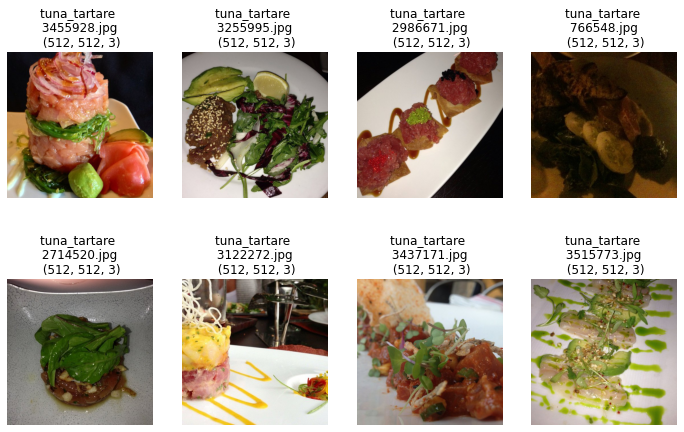

In [28]:
view_random_images('101_food_classes_10_percent/test/', random.choice(food_classes), how_many=8)

In [29]:
## Double-check if pixel values are being rescaled
for elem in train_data:
  print(elem[0][0])
  break

[[[0.         0.04705883 0.        ]
  [0.06666667 0.12156864 0.0627451 ]
  [0.11764707 0.16862746 0.09019608]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.04313726 0.        ]
  [0.04705883 0.10196079 0.04313726]
  [0.12941177 0.18039216 0.10980393]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.04313726 0.00392157]
  [0.00392157 0.04705883 0.        ]
  [0.11764707 0.16078432 0.09411766]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.3803922  0.40784317 0.3372549 ]
  [0.37647063 0.4039216  0.33333334]
  [0.37254903 0.40000004 0.32941177]
  ...
  [0.00392157 0.         0.00784314]
  [0.00784314 0.         0.01960784]
  [0.00784314 0.         0.00392157]]

 [[0.37254903 0.40000004 0.32941177]
  [0.38431376 0.41176474 0.34117648]


# Build and train a ResNet50V2 feature extract model on 10% Food101 data (baseline)

In [30]:
js_model_path = "resnet_js_model"
saved_model_path = "resnet_model"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

resnet_feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False,
                                         name="feature_extraction_layer")


x = resnet_feature_extractor_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)


outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [31]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)
resnet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 101)               206949    
                                                                 
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


Saving TensorBoard log files to: tensorflow_hub/simple_feature_extract_resnet50V2_dropout_03/20220131-074440
Epoch 1/5
237/237 [==============================] - 73s 287ms/step - loss: 3.5452 - accuracy: 0.2172 - val_loss: 2.2965 - val_accuracy: 0.4118
Epoch 2/5
237/237 [==============================] - 69s 291ms/step - loss: 2.0714 - accuracy: 0.4822 - val_loss: 2.1969 - val_accuracy: 0.4395
Epoch 3/5
237/237 [==============================] - 66s 276ms/step - loss: 1.6008 - accuracy: 0.5778 - val_loss: 2.0767 - val_accuracy: 0.4644
Epoch 4/5
237/237 [==============================] - 70s 294ms/step - loss: 1.2971 - accuracy: 0.6573 - val_loss: 2.0080 - val_accuracy: 0.4818
Epoch 5/5
237/237 [==============================] - 69s 293ms/step - loss: 1.0890 - accuracy: 0.7100 - val_loss: 2.0921 - val_accuracy: 0.4711


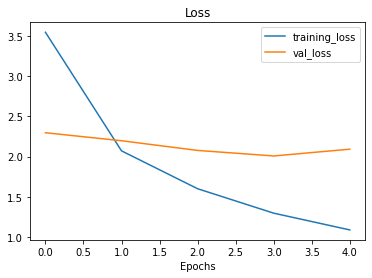

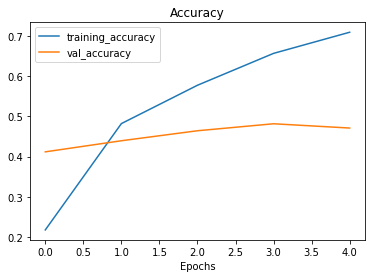

In [32]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "simple_feature_extract_resnet50V2_dropout_03")]
                                 )
plot_loss_curves(resnet_history)

In [33]:
resnet_model.evaluate(test_data)

790/790 [==============================] - 164s 208ms/step - loss: 2.0878 - accuracy: 0.4775


[2.0878164768218994, 0.4775049388408661]

In [34]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
resnet_model.save(saved_model_path)

# Save model backup to Google Drive 
resnet_model.save(save_dir+saved_model_path)


INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/resnet_js_model/resnet_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/resnet_js_model/resnet_model/assets


## Convert ResNet model to TFJS

In [35]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

     |████████████████████████████████| 77 kB 3.2 MB/s 


In [36]:
!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

2022-01-31 07:54:34.600251: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file resnet_js_model/model.json...
  adding: resnet_js_model/ (stored 0%)
  adding: resnet_js_model/group1-shard14of23.bin (deflated 7%)
  adding: resnet_js_model/group1-shard16of23.bin (deflated 7%)
  adding: resnet_js_model/group1-shard7of23.bin (deflated 7%)
  adding: resnet_js_model/group1-shard23of23.bin (deflated 6%)
  adding: resnet_js_model/group1-shard11of23.bin (deflated 7%)
  adding: resnet_js_model/group1-shard21of23.bin (deflated 7%)
  adding: resnet_js_model/model.json (deflated 97%)
  adding: resnet_js_model/group1-shard9of23.bin (deflated 7%)
  adding: resnet_js_model/group1-shard6of23.bin (deflated 7%)
  adding: resnet_js_model/group1-shard20of23.bin (deflated 7%)
  adding: resnet_js_model/group1-shard22of23.bin (deflated 7%)
  adding: resn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Build and train a MobileNet V2 feature extraction model on 10% Food101 data

In [37]:
js_model_path = "mobilenet_v2_js_model"
saved_model_path = "mobilenet_v2_model"

mobile_net_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

feature_extract_layer = hub.KerasLayer(mobile_net_v2_url,
                                         trainable=False,
                                         name="feature_extract_layer")

x = feature_extract_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extract_layer (Kera  (None, 1280)             2257984   
 sLayer)                                                         
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


Saving TensorBoard log files to: tensorflow_hub/feature_extract_mobile_net_v2/20220131-075558
Epoch 1/5
237/237 [==============================] - 80s 294ms/step - loss: 3.4465 - accuracy: 0.2154 - val_loss: 2.3559 - val_accuracy: 0.4094
Epoch 2/5
237/237 [==============================] - 59s 248ms/step - loss: 2.0761 - accuracy: 0.4809 - val_loss: 2.0289 - val_accuracy: 0.4767
Epoch 3/5
237/237 [==============================] - 57s 241ms/step - loss: 1.6543 - accuracy: 0.5766 - val_loss: 1.8898 - val_accuracy: 0.5162
Epoch 4/5
237/237 [==============================] - 57s 239ms/step - loss: 1.4137 - accuracy: 0.6265 - val_loss: 1.8547 - val_accuracy: 0.5202
Epoch 5/5
237/237 [==============================] - 56s 238ms/step - loss: 1.2140 - accuracy: 0.6809 - val_loss: 1.8180 - val_accuracy: 0.5273


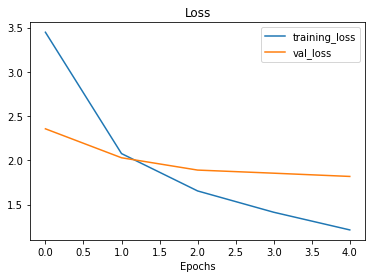

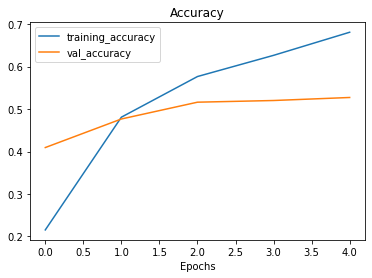

In [38]:
model_history = model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "feature_extract_mobile_net_v2")]
                                 )
plot_loss_curves(model_history)

### MobileNetV2 on the same data performs better than ResNet50


In [39]:
# 52% vs 46% on ResNet, despite on 2.4M params (ResNet is 23.7M)
model.evaluate(test_data)

790/790 [==============================] - 147s 186ms/step - loss: 1.8436 - accuracy: 0.5225


[1.8436241149902344, 0.5225346684455872]

In [40]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
model.save(saved_model_path)

# Save model backup to Google Drive 
model.save(save_dir+saved_model_path)

INFO:tensorflow:Assets written to: mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_js_model/mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_js_model/mobilenet_v2_model/assets


In [41]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

2022-01-31 08:05:16.080639: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file mobilenet_v2_js_model/model.json...
  adding: mobilenet_v2_js_model/ (stored 0%)
  adding: mobilenet_v2_js_model/group1-shard1of3.bin (deflated 7%)
  adding: mobilenet_v2_js_model/model.json (deflated 97%)
  adding: mobilenet_v2_js_model/group1-shard2of3.bin (deflated 7%)
  adding: mobilenet_v2_js_model/group1-shard3of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Download 100% of Food101

In [42]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [43]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In [44]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQVANFK/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQVANFK/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [45]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [46]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [47]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [48]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [49]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name (str form): french_onion_soup
        


In [50]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

In [51]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

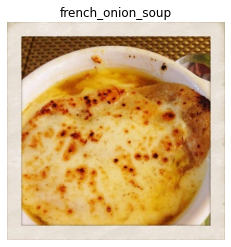

In [52]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [53]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape

  return tf.cast(image/255., tf.float32), label # return (float32_image, label) tuple

In [54]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[0.76128453 0.6828531  0.5848139 ]
  [0.802601   0.7241696  0.6261304 ]
  [0.77729094 0.7075431  0.6229492 ]
  ...
  [0.7847942  0.73157275 0.63129246]
  [0.8009     0.745998   0.64403725]
  [0.7652615  0.7025164  0.60447717]]

 [[0.77294916 0.6945178  0.58863544]
  [0.7941576  0.72749096 0.6255302 ]
  [0.82338935 0.76014405 0.6646258 ]
  ...
  [0.78941566 0.7361942  0.6359139 ]
  [0.81514585 0.7602439  0.6582831 ]
  [0.77340394 0.718502   0.6165412 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


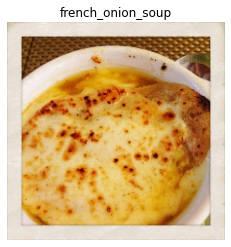

In [55]:

plt.imshow(preprocessed_img)
plt.title(class_names[label])
plt.axis(False);

In [56]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [58]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [59]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 
mixed_precision.set_global_policy(policy=None)

In [60]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "float32">

# Train ResNet50V2 on 100% Food101 data

In [61]:
js_model_path = "resnet_100pc_js_model"
saved_model_path = "resnet_100pc__model"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

resnet_feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False,
                                         name="feature_extraction_layer")


x = resnet_feature_extractor_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)


outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [62]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)
resnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 101)               206949    
                                                                 
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


Epoch 1/5
2368/2368 [==============================] - 486s 199ms/step - loss: 2.4797 - accuracy: 0.4178 - val_loss: 1.6939 - val_accuracy: 0.5562
Epoch 2/5
2368/2368 [==============================] - 473s 199ms/step - loss: 2.0272 - accuracy: 0.5080 - val_loss: 1.6560 - val_accuracy: 0.5756
Epoch 3/5
2368/2368 [==============================] - 472s 199ms/step - loss: 1.9299 - accuracy: 0.5283 - val_loss: 1.6900 - val_accuracy: 0.5684
Epoch 4/5
2368/2368 [==============================] - 473s 199ms/step - loss: 1.8832 - accuracy: 0.5390 - val_loss: 1.6943 - val_accuracy: 0.5712
Epoch 5/5
2368/2368 [==============================] - 473s 199ms/step - loss: 1.8586 - accuracy: 0.5457 - val_loss: 1.6700 - val_accuracy: 0.5819


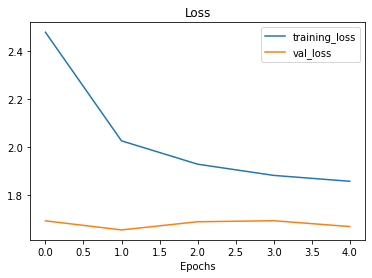

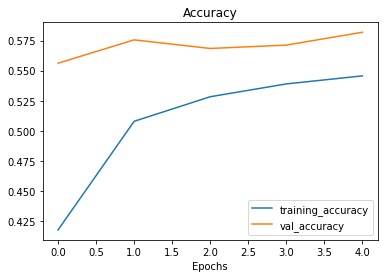

In [63]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data))
                                 )
plot_loss_curves(resnet_history)

## Save and convert ResNet to TFSJ

In [64]:
# 58% accuracy using 100% data vs 46% on 10% of data
resnet_model.evaluate(test_data)

790/790 [==============================] - 150s 190ms/step - loss: 1.6550 - accuracy: 0.5840


[1.6549948453903198, 0.5839604139328003]

In [65]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
resnet_model.save(saved_model_path)

# Save model backup to Google Drive 
resnet_model.save(save_dir+saved_model_path)

INFO:tensorflow:Assets written to: resnet_100pc__model/assets


INFO:tensorflow:Assets written to: resnet_100pc__model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/resnet_100pc_js_model/resnet_100pc__model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/resnet_100pc_js_model/resnet_100pc__model/assets


In [66]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

2022-01-31 08:58:50.180205: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file resnet_100pc_js_model/model.json...
  adding: resnet_100pc_js_model/ (stored 0%)
  adding: resnet_100pc_js_model/group1-shard14of23.bin (deflated 7%)
  adding: resnet_100pc_js_model/group1-shard16of23.bin (deflated 7%)
  adding: resnet_100pc_js_model/group1-shard7of23.bin (deflated 7%)
  adding: resnet_100pc_js_model/group1-shard23of23.bin (deflated 6%)
  adding: resnet_100pc_js_model/group1-shard11of23.bin (deflated 7%)
  adding: resnet_100pc_js_model/group1-shard21of23.bin (deflated 7%)
  adding: resnet_100pc_js_model/model.json (deflated 97%)
  adding: resnet_100pc_js_model/group1-shard9of23.bin (deflated 7%)
  adding: resnet_100pc_js_model/group1-shard6of23.bin (deflated 7%)
  adding: resnet_100pc_js_model/group1-shard20of23.bin (deflated 7%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train MobileNetV2 feature extraction model on 100% Food101 data

In [67]:
js_model_path = "mobilenet_v2_100pc_js_model"
saved_model_path = "mobilenet_v2_100pc_model"

mobile_net_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

feature_extract_layer = hub.KerasLayer(mobile_net_v2_url,
                                         trainable=False,
                                         name="feature_extract_layer")

x = feature_extract_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extract_layer (Kera  (None, 1280)             2257984   
 sLayer)                                                         
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


In [68]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)
resnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 101)               206949    
                                                                 
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


Saving TensorBoard log files to: tensorflow_hub/feature_extract_mobile_net_v2/20220131-090004
Epoch 1/5
2368/2368 [==============================] - 241s 97ms/step - loss: 2.2513 - accuracy: 0.4528 - val_loss: 1.5483 - val_accuracy: 0.5862
Epoch 2/5
2368/2368 [==============================] - 218s 91ms/step - loss: 1.8196 - accuracy: 0.5411 - val_loss: 1.4464 - val_accuracy: 0.6199
Epoch 3/5
2368/2368 [==============================] - 218s 91ms/step - loss: 1.7323 - accuracy: 0.5586 - val_loss: 1.4576 - val_accuracy: 0.6084
Epoch 4/5
2368/2368 [==============================] - 216s 90ms/step - loss: 1.6944 - accuracy: 0.5694 - val_loss: 1.4359 - val_accuracy: 0.6088
Epoch 5/5
2368/2368 [==============================] - 215s 90ms/step - loss: 1.6728 - accuracy: 0.5724 - val_loss: 1.4454 - val_accuracy: 0.6199


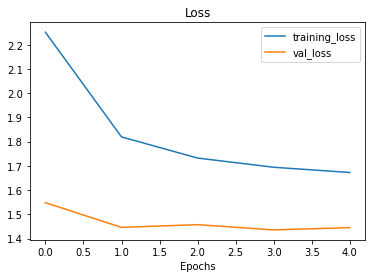

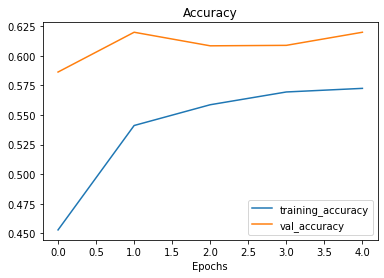

In [69]:
model_history = model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "feature_extract_mobile_net_v2")]
                                 )
plot_loss_curves(model_history)

In [70]:
# 61% on full data vs 52% on 10%
model.evaluate(test_data)

790/790 [==============================] - 65s 82ms/step - loss: 1.4706 - accuracy: 0.6150


[1.4706320762634277, 0.6150494813919067]

In [71]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
model.save(saved_model_path)

# Save model backup to Google Drive 
model.save(save_dir+saved_model_path)

INFO:tensorflow:Assets written to: mobilenet_v2_100pc_model/assets


INFO:tensorflow:Assets written to: mobilenet_v2_100pc_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_100pc_js_model/mobilenet_v2_100pc_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_100pc_js_model/mobilenet_v2_100pc_model/assets


In [72]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

2022-01-31 09:21:12.670840: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file mobilenet_v2_100pc_js_model/model.json...
  adding: mobilenet_v2_100pc_js_model/ (stored 0%)
  adding: mobilenet_v2_100pc_js_model/group1-shard1of3.bin (deflated 7%)
  adding: mobilenet_v2_100pc_js_model/model.json (deflated 97%)
  adding: mobilenet_v2_100pc_js_model/group1-shard2of3.bin (deflated 7%)
  adding: mobilenet_v2_100pc_js_model/group1-shard3of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>